In [78]:
from dataclasses import dataclass, field
from random import shuffle
from typing import Literal
import pickle

import h5py
import henon_map_cpp as hm
import matplotlib.pyplot as plt
import numpy as np
import pyarrow as pa
from numba import njit
from tqdm import tqdm

from config_standard import (CoordinateConfig, HenonConfig, OutputConfig,
                             TrackingConfig)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from postprocessings import compute_RE

In [71]:
extent = [0, 0.25, 0, 0.25]

In [31]:
with open('output/RE.pkl', 'rb') as f:
    re_data = pickle.load(f)

In [36]:
with open('output/FMA.pkl', 'rb') as f:
    fma_data = pickle.load(f)

In [37]:
with open('output/MEGNO.pkl', 'rb') as f:
    megno_data = pickle.load(f)

In [60]:
f = h5py.File("output/tangent_stuff.h5", 'r')
t_keys = list(sorted([int(l) for l in f.keys()]))
fli_x_data = []
fli_px_data = []
fli_y_data = []
fli_py_data = []
gali_data = []
le_data = []
for i in tqdm(t_keys):
    fli_x_data.append(f[f"{i}/fli_base_x"][:])
    fli_px_data.append(f[f"{i}/fli_base_px"][:])
    fli_y_data.append(f[f"{i}/fli_base_y"][:])
    fli_py_data.append(f[f"{i}/fli_base_py"][:])

    gali_data.append(f[f"{i}/gali"][:])
    le_data.append(f[f"{i}/lyapunov_error"][:])

f.close()

100%|██████████| 10000/10000 [00:51<00:00, 194.36it/s]


In [59]:
f['10'].keys()

<KeysViewHDF5 ['fli_base_px', 'fli_base_py', 'fli_base_x', 'fli_base_y', 'gali', 'lyapunov_error']>

In [54]:
f_rem = h5py.File("output/rem.h5", 'r')
t_keys = list(sorted([int(l) for l in f_rem.keys()]))
rem_data = []
for i in tqdm(t_keys[1:]):
    rem = np.sqrt(
        +(f_rem["0/x"][:] - f_rem[f"{i}/x"][:])**2
        +(f_rem["0/px"][:] - f_rem[f"{i}/px"][:])**2
        +(f_rem["0/y"][:] - f_rem[f"{i}/y"][:])**2
        +(f_rem["0/py"][:] - f_rem[f"{i}/py"][:])**2
    )
    rem_data.append(rem)
f_rem.close()

In [233]:
rem_data = np.asarray(rem_data)

In [64]:
f = h5py.File("output/four_stability.h5", 'r')
stability = f["stability"][:]
f.close()

In [218]:
tmp = np.linspace(0, 0.25, 100)
xx, yy = np.meshgrid(tmp, tmp)
x_0 = xx.flatten()
y_0 = yy.flatten()

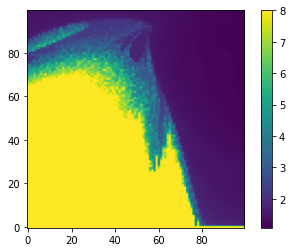

In [65]:
plt.imshow(np.log10(stability).reshape(100, 100), origin="lower")
plt.colorbar()

Text(0.5, 1.0, '$N = 10^4$')

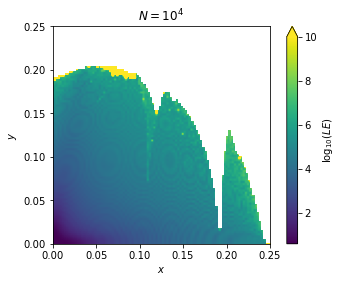

In [119]:
plt.imshow(np.log10(le_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar(extend="max", label="$\\log_{{10}}(LE)$")
plt.title("$N = 10^4$")

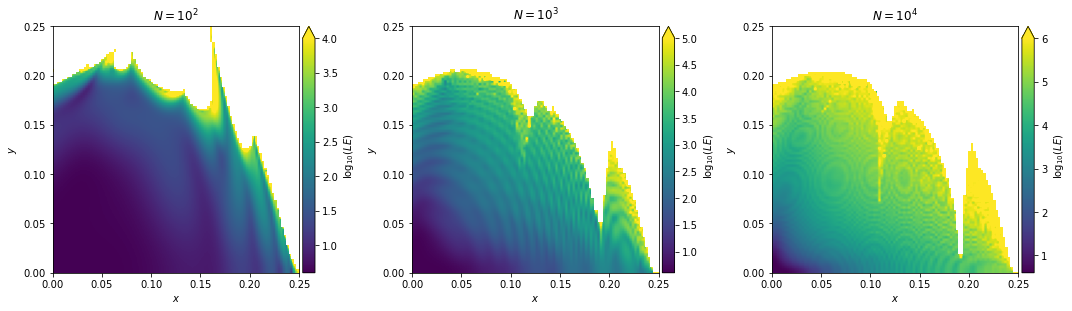

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(np.log10(le_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=4)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$\\log_{{10}}(LE)$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(np.log10(le_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$\\log_{{10}}(LE)$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow(np.log10(le_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$\\log_{{10}}(LE)$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/LE.jpg", dpi=300)

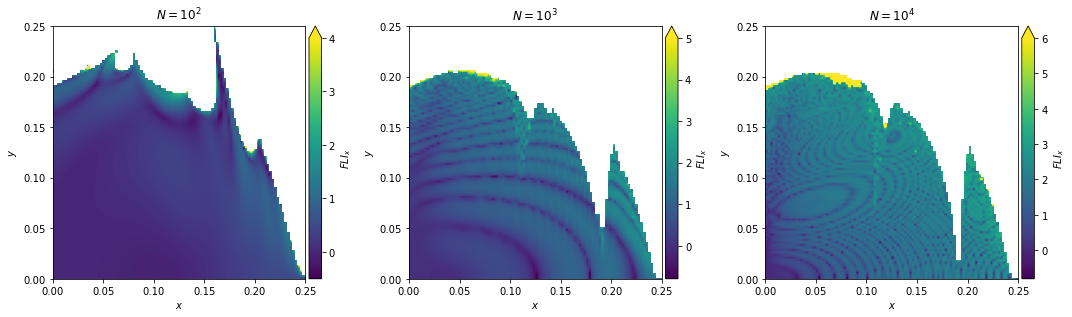

In [186]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow((fli_x_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=4)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_x$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow((fli_x_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_x$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow((fli_x_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_x$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/FLI_x.jpg", dpi=300)


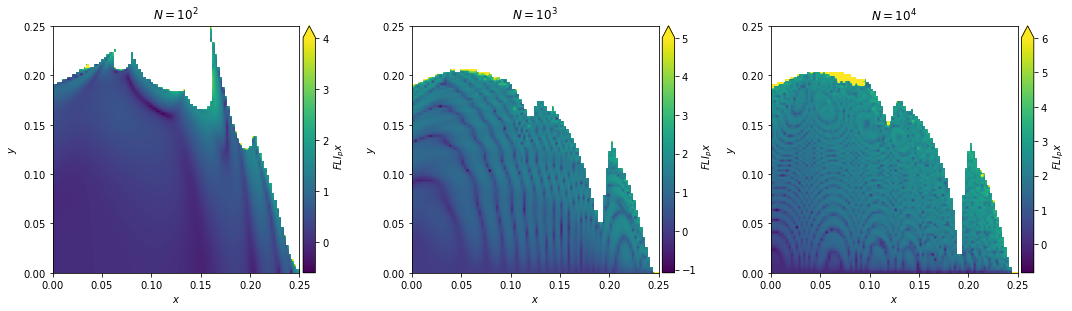

In [187]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow((fli_px_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=4)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_px$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow((fli_px_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_px$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow((fli_px_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_px$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/FLI_px.jpg", dpi=300)


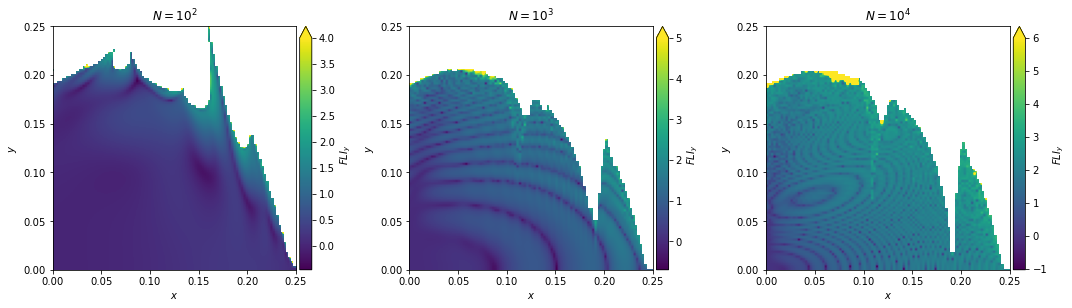

In [188]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow((fli_y_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=4)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_y$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow((fli_y_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_y$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow((fli_y_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_y$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/FLI_y.jpg", dpi=300)


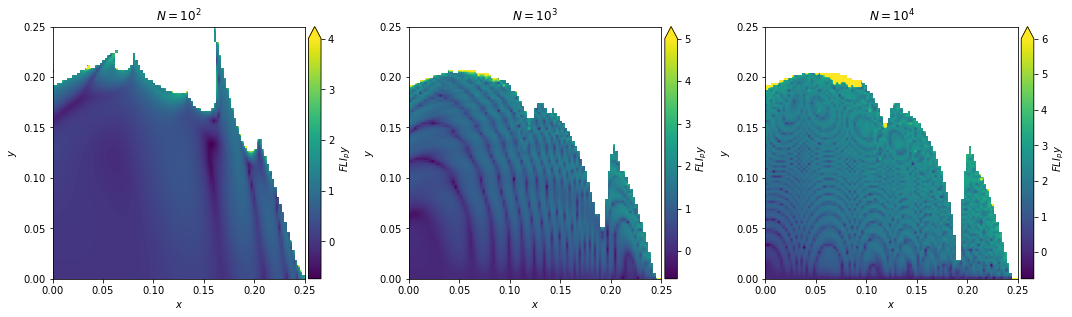

In [189]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow((fli_py_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=4)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_py$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow((fli_py_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_py$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow((fli_py_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$FLI_py$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/FLI_py.jpg", dpi=300)


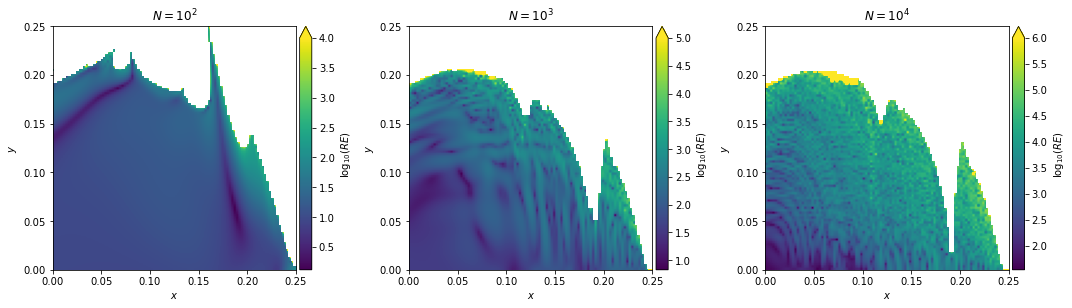

In [190]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(np.log10(re_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=4)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$\\log_{{10}}(RE)$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(np.log10(re_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=5)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$\\log_{{10}}(RE)$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow(np.log10(re_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', extend="max", label="$\\log_{{10}}(RE)$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/RE.jpg", dpi=300)


In [138]:
fli_x_data = np.asarray(fli_x_data)
fli_px_data = np.asarray(fli_px_data)
fli_y_data = np.asarray(fli_y_data)
fli_py_data = np.asarray(fli_py_data)

Text(0.5, 1.0, '$x_0 = 0.10, y_0 = 0.19$')

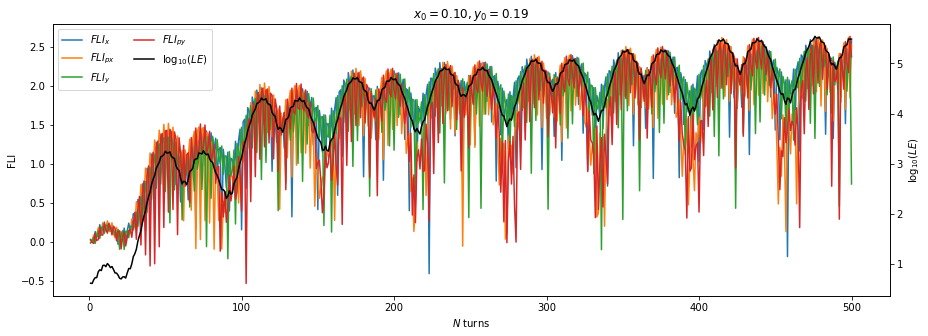

In [221]:
plt.figure(figsize=(15, 5))
idx = 7640
max_t = 500
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")

Text(0.5, 1.0, '$x_0 = 0.08, y_0 = 0.19$')

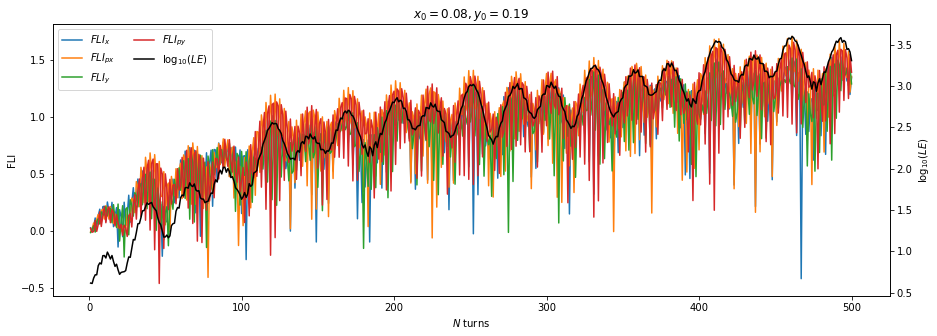

In [222]:
plt.figure(figsize=(15, 5))
idx = 7630
max_t = 500
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")


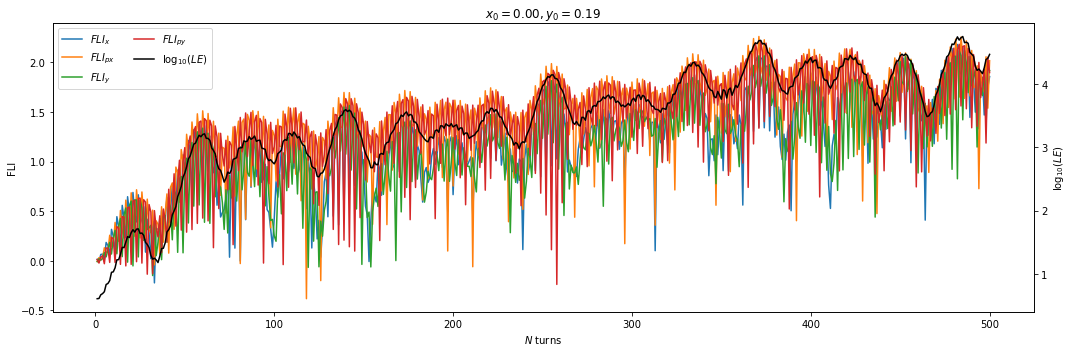

In [235]:
plt.figure(figsize=(15, 5))
idx = 7500
max_t = 500
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")

plt.tight_layout()
plt.savefig("img/base/example_4.jpg", dpi=300)

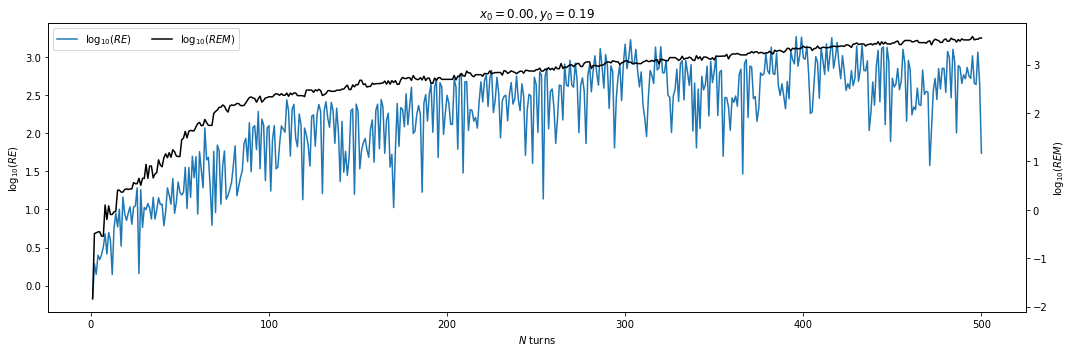

In [237]:
plt.figure(figsize=(15, 5))
idx = 7500
max_t = 500
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(re_data[:max_t, idx]), label="$\\log_{{10}}(RE)$")
plt.ylabel("$\\log_{{10}}(RE)$")
plt.plot([], [], label="$\\log_{{10}}(REM)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), 16+np.log10(rem_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(REM)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")

plt.tight_layout()
plt.savefig("img/base/example_re_4.jpg", dpi=300)

Text(0, 0.5, '$\\log_{{10}}(LE)$')

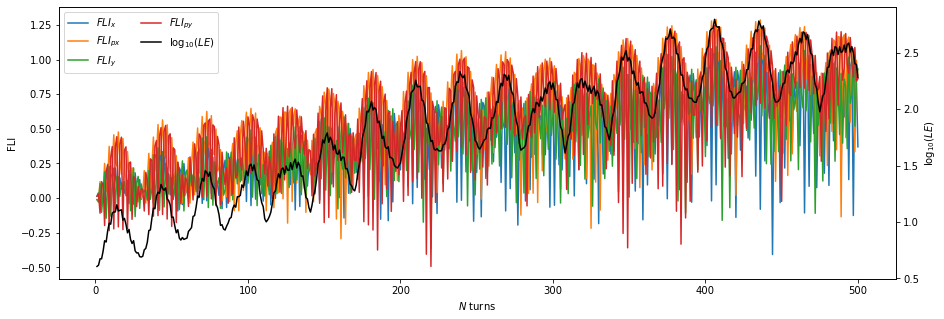

In [155]:
plt.figure(figsize=(15, 5))
idx = 2570
max_t = 500
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")

Text(0.5, 1.0, '$x_0 = 0.10, y_0 = 0.19$')

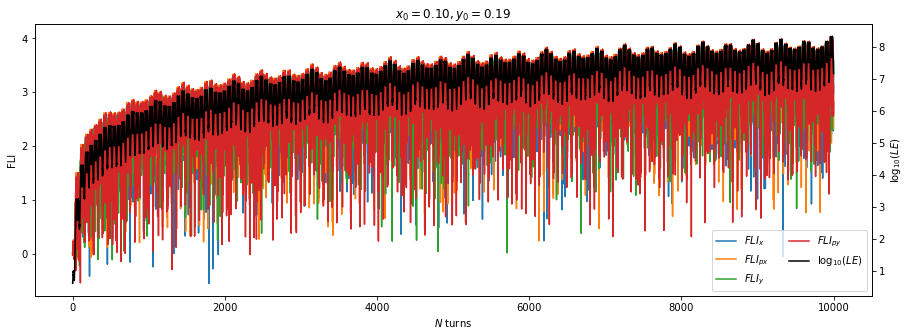

In [223]:
plt.figure(figsize=(15, 5))
idx = 7640
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")


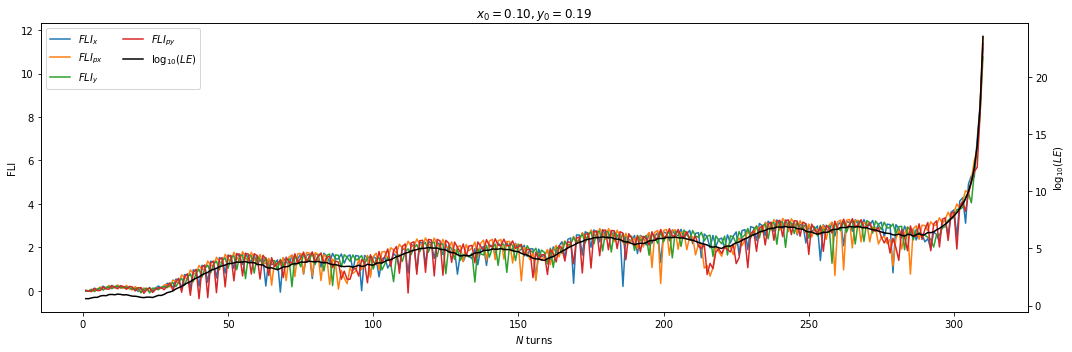

In [229]:
plt.figure(figsize=(15, 5))
idx = 7641
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")
plt.tight_layout()
plt.savefig("img/base/example_3.jpg", dpi=300)

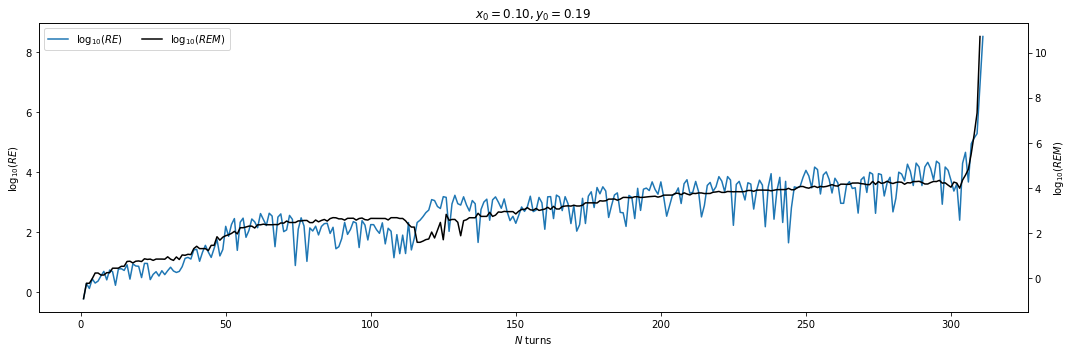

In [238]:
plt.figure(figsize=(15, 5))
idx = 7641
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(re_data[:max_t, idx]), label="$\\log_{{10}}(RE)$")
plt.ylabel("$\\log_{{10}}(RE)$")
plt.plot([], [], label="$\\log_{{10}}(REM)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), 16+np.log10(rem_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(REM)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")

plt.tight_layout()
plt.savefig("img/base/example_re_3.jpg", dpi=300)

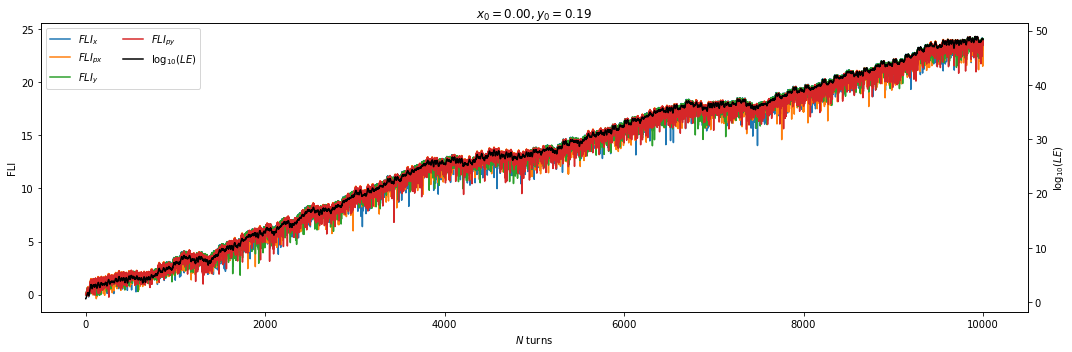

In [228]:
plt.figure(figsize=(15, 5))
idx = 7500
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")
plt.tight_layout()
plt.savefig("img/base/example_2.jpg", dpi=300)

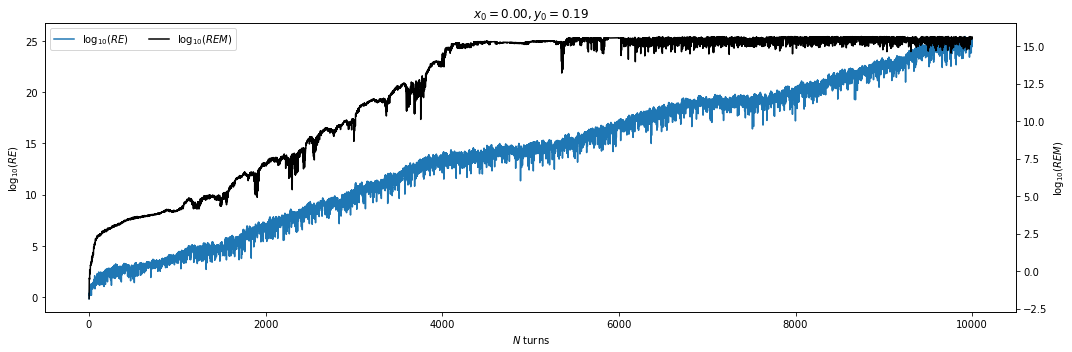

In [239]:
plt.figure(figsize=(15, 5))
idx = 7500
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(re_data[:max_t, idx]), label="$\\log_{{10}}(RE)$")
plt.ylabel("$\\log_{{10}}(RE)$")
plt.plot([], [], label="$\\log_{{10}}(REM)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), 16+np.log10(rem_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(REM)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")

plt.tight_layout()
plt.savefig("img/base/example_re_2.jpg", dpi=300)

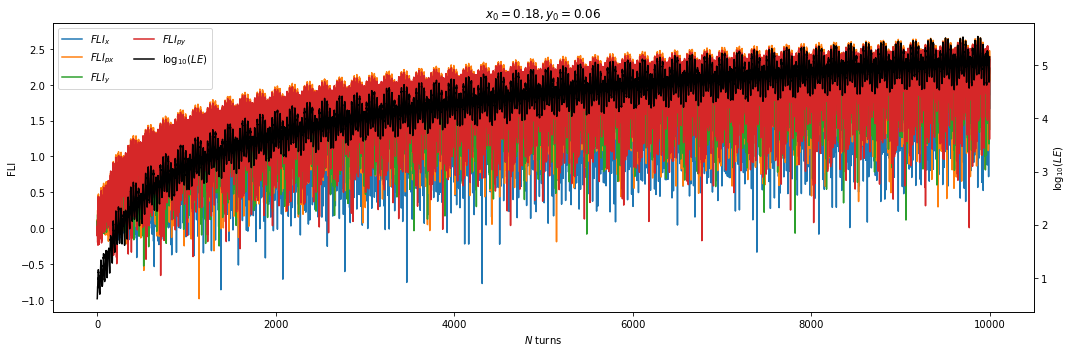

In [227]:
plt.figure(figsize=(15, 5))
idx = 2570
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_x_data[:max_t, idx], label="$FLI_{{x}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_px_data[:max_t, idx], label="$FLI_{{px}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_y_data[:max_t, idx], label="$FLI_{{y}}$")
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), fli_py_data[:max_t, idx], label="$FLI_{{py}}$")
plt.plot([], [], label="$\\log_{{10}}(LE)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.ylabel("FLI")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(le_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(LE)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")
plt.tight_layout()
plt.savefig("img/base/example_1.jpg", dpi=300)


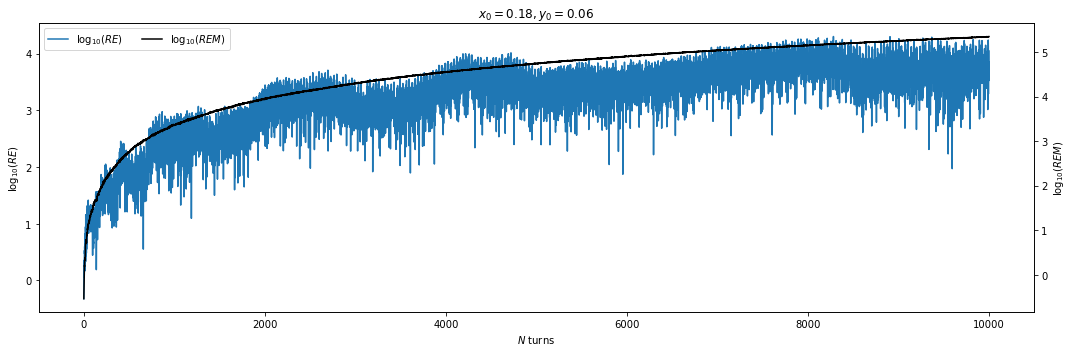

In [240]:
plt.figure(figsize=(15, 5))
idx = 2570
max_t = -1
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), np.log10(re_data[:max_t, idx]), label="$\\log_{{10}}(RE)$")
plt.ylabel("$\\log_{{10}}(RE)$")
plt.plot([], [], label="$\\log_{{10}}(REM)$", c="black")
plt.legend(ncol=2)
plt.xlabel("$N$ turns")
plt.twinx()
plt.plot(np.arange(1, len(fli_x_data[:max_t, idx])+1), 16+np.log10(rem_data[:max_t, idx]), c="black")
plt.ylabel("$\\log_{{10}}(REM)$")
plt.title(f"$x_0 = {x_0[idx]:.2f}, y_0 = {y_0[idx]:.2f}$")

plt.tight_layout()
plt.savefig("img/base/example_re_1.jpg", dpi=300)

/tmp/ipykernel_8107/2429248806.py:3: RuntimeWarning: divide by zero encountered in log10
  im = axs[0].imshow(np.log10(fma_data[1][20]).reshape(100, 100), origin="lower", extent=extent)
/tmp/ipykernel_8107/2429248806.py:11: RuntimeWarning: divide by zero encountered in log10
  im = axs[1].imshow(np.log10(fma_data[1][200]).reshape(100, 100), origin="lower", extent=extent)


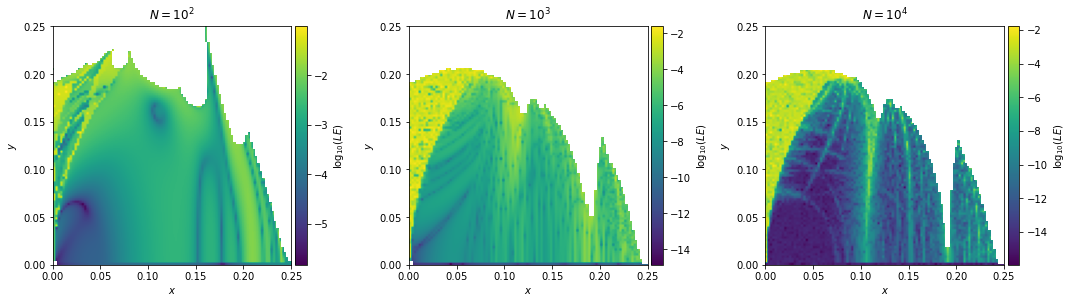

In [191]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(np.log10(fma_data[1][20]).reshape(100, 100), origin="lower", extent=extent)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(LE)$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(np.log10(fma_data[1][200]).reshape(100, 100), origin="lower", extent=extent)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(LE)$")
axs[1].set_title("$N = 10^3$")

data = fma_data[1][-1]
data[data==0.0] = 1e-15
im = axs[2].imshow(np.log10(data).reshape(100, 100), origin="lower", extent=extent)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(LE)$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/FMA.jpg", dpi=300)


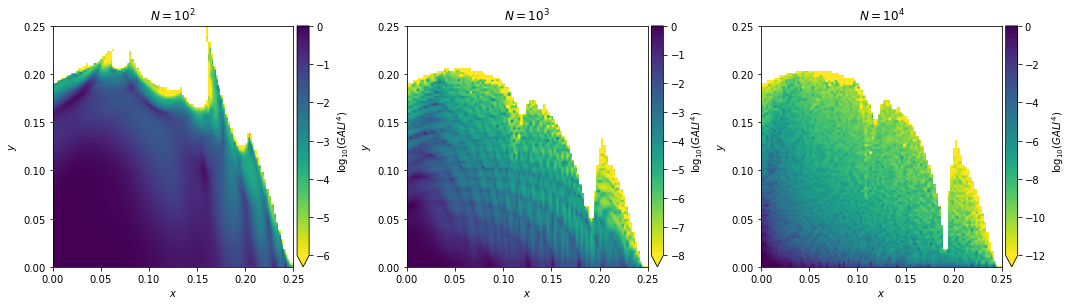

In [241]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(np.log10(gali_data[100]).reshape(100, 100), origin="lower", extent=extent, vmin=-6, cmap="viridis_r")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(GALI^4)$", extend="min", cmap="viridis_r")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(np.log10(gali_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmin=-8, cmap="viridis_r")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(GALI^4)$", extend="min")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow(np.log10(gali_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmin=-12, cmap="viridis_r")
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(GALI^4)$", extend="min")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/eps_0_mu_0/gali.jpg", dpi=300)

/tmp/ipykernel_8107/2519026449.py:3: RuntimeWarning: divide by zero encountered in log10
  im = axs[0].imshow(2*np.log10(rem_data[100]*1e16).reshape(100, 100), origin="lower", extent=extent)
/tmp/ipykernel_8107/2519026449.py:11: RuntimeWarning: divide by zero encountered in log10
  im = axs[1].imshow(2*np.log10(rem_data[1000]*1e16).reshape(100, 100), origin="lower", extent=extent)
/tmp/ipykernel_8107/2519026449.py:19: RuntimeWarning: divide by zero encountered in log10
  im = axs[2].imshow(2*np.log10(rem_data[-1]*1e16).reshape(100, 100), origin="lower", extent=extent)


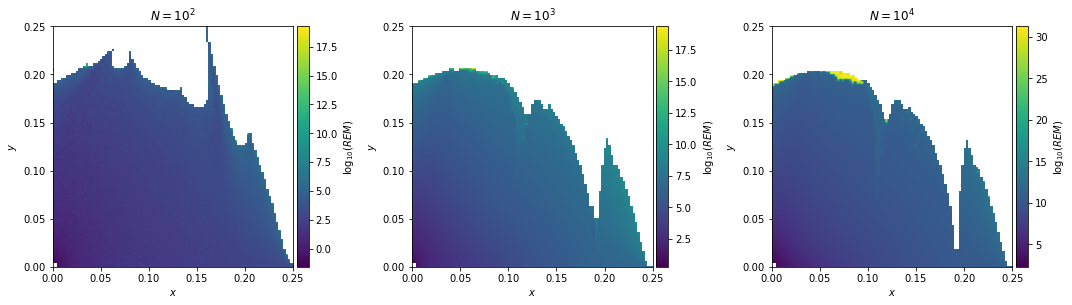

In [196]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(2*np.log10(rem_data[100]*1e16).reshape(100, 100), origin="lower", extent=extent)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(REM)$")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(2*np.log10(rem_data[1000]*1e16).reshape(100, 100), origin="lower", extent=extent)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(REM)$")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow(2*np.log10(rem_data[-1]*1e16).reshape(100, 100), origin="lower", extent=extent)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(REM)$")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/REM.jpg", dpi=300)

/tmp/ipykernel_8107/1307459138.py:3: RuntimeWarning: divide by zero encountered in log10
  im = axs[0].imshow(2*np.log10(rem_data[100]*1e16).reshape(100, 100), origin="lower", extent=extent, vmax=6)
/tmp/ipykernel_8107/1307459138.py:11: RuntimeWarning: divide by zero encountered in log10
  im = axs[1].imshow(2*np.log10(rem_data[1000]*1e16).reshape(100, 100), origin="lower", extent=extent, vmax=9)
/tmp/ipykernel_8107/1307459138.py:19: RuntimeWarning: divide by zero encountered in log10
  im = axs[2].imshow(2*np.log10(rem_data[-1]*1e16).reshape(100, 100), origin="lower", extent=extent, vmax=13)


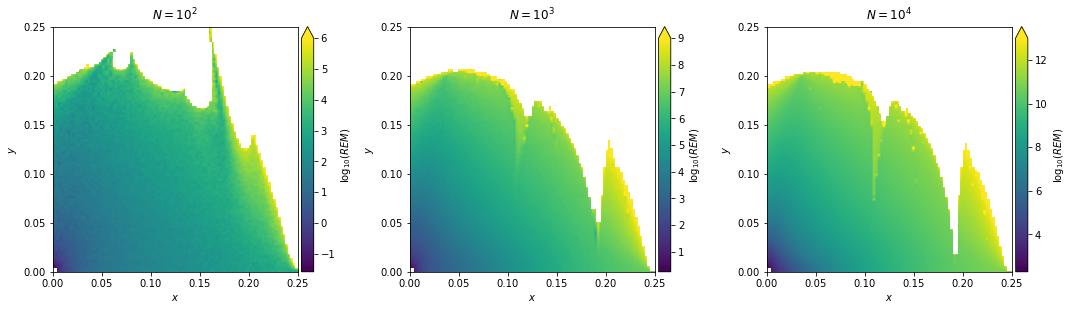

In [204]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(2*np.log10(rem_data[100]*1e16).reshape(100, 100), origin="lower", extent=extent, vmax=6)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(REM)$", extend="max")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(2*np.log10(rem_data[1000]*1e16).reshape(100, 100), origin="lower", extent=extent, vmax=9)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(REM)$", extend="max")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow(2*np.log10(rem_data[-1]*1e16).reshape(100, 100), origin="lower", extent=extent, vmax=13)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$\\log_{{10}}(REM)$", extend="max")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/REM_zoomed.jpg", dpi=300)

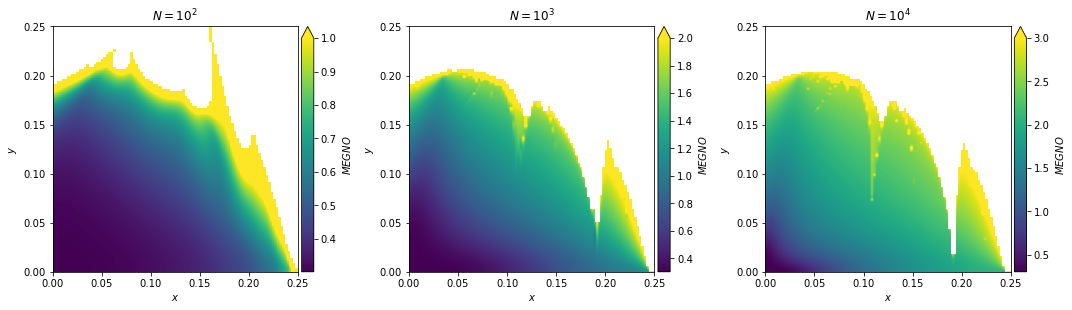

In [205]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

im = axs[0].imshow(np.log10(megno_data[100]).reshape(100, 100), origin="lower", extent=extent, vmax=1)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$MEGNO$", extend="max")
axs[0].set_title("$N = 10^2$")

im = axs[1].imshow(np.log10(megno_data[1000]).reshape(100, 100), origin="lower", extent=extent, vmax=2)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$MEGNO$", extend="max")
axs[1].set_title("$N = 10^3$")

im = axs[2].imshow(np.log10(megno_data[-1]).reshape(100, 100), origin="lower", extent=extent, vmax=3)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label="$MEGNO$", extend="max")
axs[2].set_title("$N = 10^4$")

plt.tight_layout()
plt.savefig("img/base/MEGNO.jpg", dpi=300)